In [2]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
%matplotlib inline

In [4]:
today = datetime.date.today().strftime("%Y%m%d")
# today = '20210221'

In [5]:
cdc_data_api_end_point = 'https://data.cdc.gov/resource/9mfq-cb36.json'

In [6]:
query_limit = '50000'

In [7]:
daily_data = pd.read_json(cdc_data_api_end_point + '?$limit=' + query_limit)

In [8]:
daily_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23820 entries, 0 to 23819
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   submission_date  23820 non-null  object        
 1   state            23820 non-null  object        
 2   tot_cases        23820 non-null  int64         
 3   new_case         23820 non-null  int64         
 4   pnew_case        18740 non-null  float64       
 5   tot_death        23820 non-null  int64         
 6   new_death        23820 non-null  int64         
 7   pnew_death       18642 non-null  float64       
 8   created_at       23820 non-null  datetime64[ns]
 9   consent_cases    21835 non-null  object        
 10  consent_deaths   21835 non-null  object        
 11  conf_death       10571 non-null  float64       
 12  prob_death       10571 non-null  float64       
 13  conf_cases       10409 non-null  float64       
 14  prob_cases       10409 non-null  float

In [9]:
daily_data.query('state=="NJ"')

submission_date state  tot_cases  new_case  pnew_case  \
7      2020-03-12T00:00:00.000    NJ         29         6        NaN   
45     2020-02-09T00:00:00.000    NJ          0         0        NaN   
102    2020-09-12T00:00:00.000    NJ     200405       476       27.0   
103    2020-04-24T00:00:00.000    NJ     102196      2207        0.0   
165    2020-05-18T00:00:00.000    NJ     148219      1720       15.0   
...                        ...   ...        ...       ...        ...   
23465  2020-08-27T00:00:00.000    NJ     193981       349       42.0   
23473  2020-07-22T00:00:00.000    NJ     179574       445       56.0   
23577  2020-09-20T00:00:00.000    NJ     204234       497       44.0   
23580  2020-04-28T00:00:00.000    NJ     113857      2669        1.0   
23607  2020-11-21T00:00:00.000    NJ     326714      5144      475.0   

       tot_death  new_death  pnew_death              created_at consent_cases  \
7              1          0         NaN 2020-03-26 16:22:39.452         Agree   
45             0          0         NaN 2020-03-26 16:22:39.452         Agree   
102        16027          4         0.0 2021-02-19 13:38:31.100     Not agree   
103         5617        249         0.0 2020-05-25 15:38:40.000         Agree   
165        10435         79         0.0 2021-02-19 13:38:31.100     Not agree   
...          ...        ...         ...                     ...           ...   
23465      15921          7         0.0 2021-02-19 13:38:31.100     Not agree   
23473      15707        -30       -54.0 2021-02-19 13:38:31.100     Not agree   
23577      16067          3         0.0 2021-02-19 13:38:31.100     Not agree   
23580       6442        398         0.0 2021-02-19 13:38:31.100     Not agree   
23607      16746         34         0.0 2021-02-19 13:38:31.100     Not agree   

      consent_deaths  conf_death  prob_death  conf_cases  prob_cases  
7              Agree         NaN         NaN         NaN         NaN  
45             Agree         NaN         NaN         NaN         NaN  
102            Agree     14238.0      1789.0         NaN         NaN  
103            Agree      5617.0         0.0    102196.0         0.0  
165            Agree     10435.0         0.0         NaN         NaN  
...              ...         ...         ...         ...         ...  
23465          Agree     14141.0      1780.0         NaN         NaN  
23473          Agree     13787.0      1920.0         NaN         NaN  
23577          Agree     14276.0      1791.0         NaN         NaN  
23580          Agree      6442.0         0.0         NaN         NaN  
23607          Agree     14934.0      1812.0         NaN         NaN  

[397 rows x 15 columns]

In [10]:
northeast_states = ['CT','DC','DE','MA','MD','ME','NH','NJ','NY','PA','RI','VA','VT','WV']
northeast_territories = ['VI','PR']
northeast = northeast_states + northeast_territories
midwest = ['IA','IL','IN','KS','MI','MN','MO','NE','OH','WI']
north_branch = northeast + midwest

In [11]:
states_daily_data = daily_data.copy()
states_daily_data['reference_date'] = pd.to_datetime(states_daily_data['submission_date'])
states_daily_data.drop(columns=['submission_date'], inplace=True)
states_daily_data.sort_values(by=['reference_date', 'state'], inplace=True)
states_daily_data.set_index('reference_date', inplace=True)

In [12]:
# Dirty fix for Jan 8th and 9th in NJ - new cases data manually interpolated
states_daily_data.set_index('state', inplace=True, append=True)
states_daily_data.loc[('2021-01-08', 'NJ'), 'new_case'] = 6674
states_daily_data.loc[('2021-01-09', 'NJ'), 'new_case'] = 6674
states_daily_data.reset_index(level = 'state', inplace=True)

In [13]:
def new_cases_table(state='US', skip=7):
    temp_table = states_daily_data.copy()
    if state == 'US':
        temp_table = temp_table.groupby('reference_date').sum()
    elif state == 'NB':
        temp_table = temp_table[temp_table['state'].isin(north_branch)].groupby('reference_date').sum()
    else:
        temp_table = temp_table.query('state == @state').groupby('reference_date').sum()
    label = 'new_cases_' + str(skip) + 'd_average'
    temp_table[label] = temp_table.new_case.rolling(window=skip).mean()
    temp_table.loc[temp_table.loc[:, label] < 0, label] = 0
    temp_table.loc[temp_table.loc[:, 'new_case'] < 0, 'new_case'] = 0
    return temp_table, label

In [14]:
def plot_new_cases(state='US', skip=7):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twiny()
    [temp_table, label] = new_cases_table(state, skip)
    temp_table.reset_index(inplace=True)
    title='Daily additional cases in ' + state + ' as of ' + today + '\n(' + str(skip) + ' days moving average in red)'
    temp_table.plot(x='reference_date', y=label, ax=ax1, color='red', figsize=(8,6), title=title)
    temp_table.plot.bar(y='new_case', ax=ax2, alpha=0.5)

    ax1.get_legend().remove()
    ax1.xaxis.set_label_text('')
    ax1.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.get_legend().remove()
    
    plt.show()


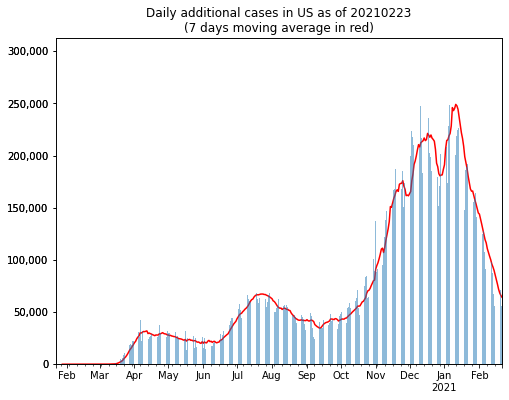

In [15]:
plot_new_cases('US')

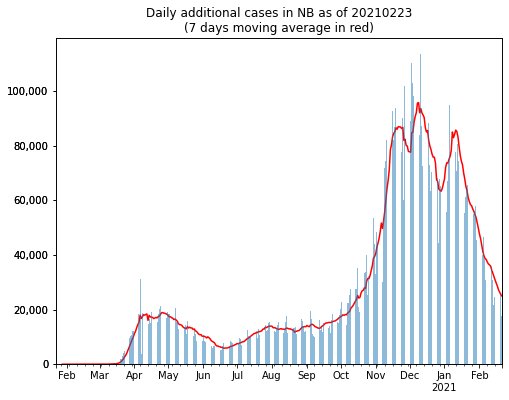

In [16]:
plot_new_cases('NB')

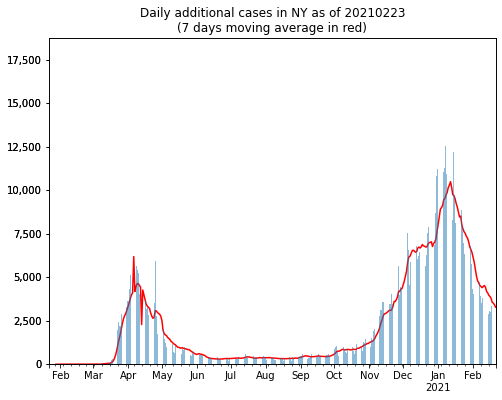

In [20]:
plot_new_cases('NY')

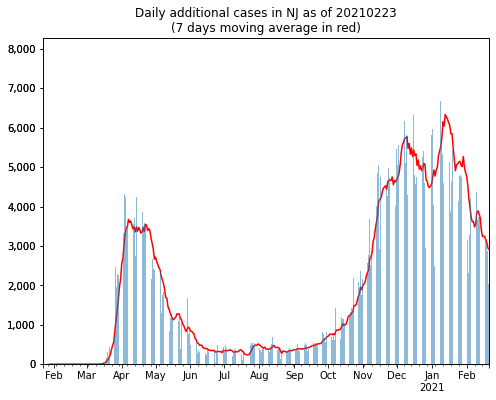

In [21]:
plot_new_cases('NJ')